# Bayesian Linear Regression fit using MFVI vs closed-form solution

In [1]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

import torch
from torch.nn.functional import softplus

In [3]:
import sys
sys.path.append("../")

In [4]:
import reparametrized as r
from reparametrized import sampling
from reparametrized import likelihoods
from reparametrized import densities

In [5]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (5, 5) # Width and height

In [6]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    env = torch.cuda
    print("Using GPU")
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    env = torch
    print("Using CPU")

Using CPU


## Data

In [7]:
SEED = 123

torch.manual_seed(SEED)
np.random.seed(SEED)

In [8]:
def generate_toy_data(N):
    x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, N))).T
    r_data = np.float32(np.random.normal(size=(N,1)))
    y_data = np.float32(np.sin(0.75*x_data)*7.0+x_data*0.5+r_data*2.0)+10
    
    mask = (x_data<0.0) | (x_data>5.0)
    r_data = r_data[mask]
    y_data = y_data[mask, None]
    x_data = x_data[mask, None]

    return x_data, y_data, r_data


x_data, y_data, r_data = generate_toy_data(100)

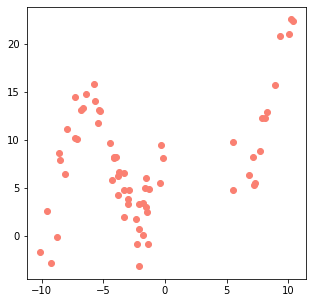

In [9]:
plt.scatter(x_data, y_data, color="salmon");

In [10]:
x = torch.tensor(x_data, dtype = torch.float, requires_grad=False)
y = torch.tensor(y_data, dtype = torch.float, requires_grad=False)

print("x=%s y=%s" % (x.shape, y.shape))

x=torch.Size([64, 1]) y=torch.Size([64, 1])


## Network

In [11]:
INPUT_DIM = 1
OUTPUT_DIM = 1

# Linear regression model
model = torch.nn.Sequential(
    torch.nn.Linear(INPUT_DIM, OUTPUT_DIM),
    )    
 

assert torch.Size([INPUT_DIM])==x.shape[1:]
assert torch.Size([OUTPUT_DIM])==y.shape[1:]

List model parameters:

In [12]:
dict(model.named_parameters()).keys()

dict_keys(['0.weight', '0.bias'])

## Priors

In [13]:
parameters2nllfunc = {}
for parameter_name, parameter_value in model.named_parameters():
    parameters2nllfunc[parameter_name] = densities.create_gaussian_nll(parameter_value.shape)

## Likelihood

In [14]:
LIKELIHOOD_SIGMA = 2

def predictive_distribution_sampler(logits, **kwargs): 
    return likelihoods.factorized_gaussian_with_fixed_scale_sample(logits, scale=LIKELIHOOD_SIGMA, **kwargs)

def predictive_distribution_log_lik(logits, output_y, **kwargs): 
    return likelihoods.factorized_gaussian_with_fixed_scale_log_prob(logits, output_y, scale=LIKELIHOOD_SIGMA, **kwargs)

## Create samplers for parameters

List of samplers and variational parameters to be optimized

In [15]:
parameters2sampler = {}
variational_params = []

is_parameter_already_handled = lambda parameter_name: r.is_parameter_handled(parameters2sampler.items(), parameter_name)

Register parameters to be modeled with factorized Gaussian

In [16]:
loc_initalization = lambda parameter: torch.randn_like(parameter) #parameter.clone().detach(),
uscale_initialization = lambda parameter: torch.randn_like(parameter)


for n, p in model.named_parameters():
    if not is_parameter_already_handled(n):
        print(f"Learning {n} with factorized Gaussian")
        sampler, variational_params1, aux_objs = sampling.create_factorized_gaussian_sampler(p, 
            loc_initalization=loc_initalization,
            uscale_initialization=uscale_initialization,
            )

        parameters2sampler[n] = sampler
        variational_params.extend((n+":"+vn, vp) for vn, vp in variational_params1.items())

Learning 0.weight with factorized Gaussian
Learning 0.bias with factorized Gaussian


# Preview sample

In [17]:
print("samplers:")
display(parameters2sampler)

samplers:


{'0.weight': <function reparametrized.sampling.gaussian.create_factorized_gaussian_sampler.<locals>.sample_factorized_gaussian(n_samples=1)>,
 '0.bias': <function reparametrized.sampling.gaussian.create_factorized_gaussian_sampler.<locals>.sample_factorized_gaussian(n_samples=1)>}

In [18]:
print("variational parameters:")
display([(vn, vp.shape) for vn, vp in variational_params])

variational parameters:


[('0.weight:loc', torch.Size([1, 1])),
 ('0.weight:unnormalized_scale', torch.Size([1, 1])),
 ('0.bias:loc', torch.Size([1])),
 ('0.bias:unnormalized_scale', torch.Size([1]))]

In [19]:
parameters_samples, nlls = r.sample_parameters(parameters2sampler.items(), 3)

In [20]:
print("parameters' sample:")
{n: s.shape for n, s in parameters_samples.items()}

parameters' sample:


{'0.weight': torch.Size([3, 1, 1]), '0.bias': torch.Size([3, 1])}

In [21]:
print("parameters' NLLs:")
nlls

parameters' NLLs:


{'0.weight': tensor([1.5438, 0.6501, 3.4862], grad_fn=<NegBackward0>),
 '0.bias': tensor([1.0825, 2.5185, 1.1836], grad_fn=<NegBackward0>)}

In [22]:
r.sample_predictive(x, model, parameters_samples, predictive_distribution_sampler, n_samples=2, flatten_samples_dims=True).shape

torch.Size([6, 64, 1])

In [23]:
r.predictive_likelihoods(x, y, model, parameters_samples, predictive_distribution_log_lik).shape

torch.Size([3, 64])

## Visualisation

In [24]:
def plot_with_errortunnel(x, y, yerr, color=None, alpha_fill=0.2, ax=None, label="", lw=1):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, y, color=color, label=label, lw=lw)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill, linewidth=0.0)
 
 
def numpy(tensor):
    return tensor.cpu().detach().numpy()


def linspace1(x):
    x2, x1 = numpy(x.flatten().max().cpu()), numpy(x.flatten().min().cpu())
    rng = (x2-x1)*0.5
    xs = np.arange(x1-rng, x2+rng, 0.5)
    xs = torch.tensor([[v] for v in xs], dtype=torch.float32)            
    return xs


def plot_fit(x, y, xs, ys, plot_samples=True, plot_error=True):  
    x, y, xs, ys = numpy(x), numpy(y), numpy(xs), numpy(ys)
    plt.scatter(x.flatten(), y.flatten(), label="data", color="salmon")
    
    if plot_samples:
        for y1 in ys:
            plt.plot(xs.flatten(), y1.flatten(), lw=1)

    ym, ys = ys.mean(0), ys.std(0)         
    if plot_error:
        plot_with_errortunnel(xs.flatten(), ym.flatten(), 2*ys.flatten(), color="dodgerblue", label="BNN (m+/-2*s", lw=2)
    else:
        plt.plot(xs.flatten(), ym.flatten(), color="dodgerblue", label="BNN", lw=2)
        
    plt.legend();

## Learning

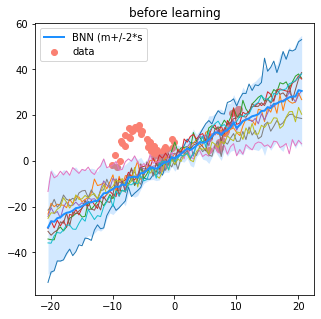

In [25]:
parameters_samples, nlls = r.sample_parameters(parameters2sampler.items(), 10)
xs = linspace1(x)
ys = r.sample_predictive(xs, model, parameters_samples, 
                        sampler=predictive_distribution_sampler, 
                        n_samples=1, 
                       )

plot_fit(x, y, xs, ys)
plt.title("before learning")
plt.show()

In [26]:
optimized_parameters = [vp for _, vp in variational_params]
optimizer = torch.optim.Adam(optimized_parameters, lr=0.01) 

n_posterior_samples = 1
n_epochs = 10000

for e in range(n_epochs):
    optimizer.zero_grad()

    # sampling from approximate posterior
    parameters_samples, posterior_nlls = r.sample_parameters(parameters2sampler, n_samples=n_posterior_samples)
    posterior_nlls = torch.stack(list(posterior_nlls.values()))  # out shape: n_param_groups x n_posterior_samples
    log_q = -posterior_nlls.sum(0)

    # priors
    prior_nlls = r.estimate_parameters_nll(parameters2nllfunc, parameters_samples)
    prior_nlls = torch.stack(list(prior_nlls.values()))  # out shape: n_param_groups x n_posterior_samples
    log_p = -prior_nlls.sum(0)

    # estimating likelihoods of observed y
    logliks = r.predictive_likelihoods(x, y, model, parameters_samples, predictive_distribution_log_lik)
    assert logliks.shape==torch.Size([n_posterior_samples, len(y)])
    logliks = logliks.sum(1) # sum over data points
    
    elbo = logliks+log_p-log_q
    elbo = elbo.mean()  # average over posterior samples

    loss_vi = -elbo
    loss_vi.backward()
    optimizer.step()

    if e<10 or e%100==0:
        print(f"epoch={e}: elbo = {elbo: .2f} (= {logliks.mean(): .2f} [+] {log_p.mean(): .2f} [-] {-log_q.mean(): .2f})")

epoch=0: elbo = -1129.31 (= -1133.66 [+] -2.36 [-]  6.70)
epoch=1: elbo = -710.74 (= -708.95 [+] -4.48 [-]  2.69)
epoch=2: elbo = -1230.81 (= -1228.98 [+] -3.42 [-]  1.59)
epoch=3: elbo = -1655.00 (= -1653.23 [+] -3.62 [-]  1.85)
epoch=4: elbo = -1341.47 (= -1338.57 [+] -4.91 [-]  2.01)
epoch=5: elbo = -1328.17 (= -1327.40 [+] -2.73 [-]  1.96)
epoch=6: elbo = -828.05 (= -830.04 [+] -2.73 [-]  4.71)
epoch=7: elbo = -1742.15 (= -1739.37 [+] -4.88 [-]  2.10)
epoch=8: elbo = -623.39 (= -620.28 [+] -7.16 [-]  4.04)
epoch=9: elbo = -886.78 (= -886.07 [+] -2.55 [-]  1.83)
epoch=100: elbo = -682.47 (= -680.88 [+] -3.18 [-]  1.59)
epoch=200: elbo = -614.40 (= -608.76 [+] -6.95 [-]  1.30)
epoch=300: elbo = -626.96 (= -624.12 [+] -4.62 [-]  1.79)
epoch=400: elbo = -548.95 (= -540.74 [+] -9.63 [-]  1.43)
epoch=500: elbo = -465.73 (= -454.09 [+] -12.04 [-]  0.40)
epoch=600: elbo = -411.13 (= -391.68 [+] -20.57 [-]  1.11)
epoch=700: elbo = -415.22 (= -397.53 [+] -17.63 [-] -0.06)
epoch=800: elbo = -

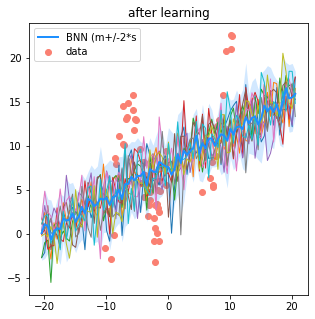

In [27]:
parameters_samples, nlls = r.sample_parameters(parameters2sampler, 10)
xs = linspace1(x)
ys = r.sample_predictive(xs, model, parameters_samples, 
                        sampler=predictive_distribution_sampler, 
                        n_samples=1, 
                       )

plot_fit(x, y, xs, ys)
plt.title("after learning")
plt.show()

# Linear Regression Bayesian true (closed-form) posterior

See Bishop's book

In [28]:
psi = np.hstack([x_data, np.ones(x_data.shape)])
t = y_data

In [29]:
psi.shape, t.shape

((64, 2), (64, 1))

In [30]:
#likelihood precision:
beta = 1./(LIKELIHOOD_SIGMA*LIKELIHOOD_SIGMA)

#prior:
S0 = np.eye(psi.shape[-1])
m0 = np.zeros(psi.shape[-1]).reshape(-1, 1)

In [31]:
SN = np.linalg.inv( np.linalg.inv(S0) + beta*np.dot(psi.T, psi) ) # covariance matrix (Bishop 3.50)

In [32]:
mN = np.dot(SN, np.dot(np.linalg.inv(S0), m0) + beta*np.dot(psi.T, t)) # means (Bishop 3.51)

Compare expectations (means):

In [33]:
mN

array([[0.37413242],
       [7.83990305]])

In [34]:
variational_params_d = dict(variational_params)
l1, l2 = variational_params_d['0.weight:loc'], variational_params_d['0.bias:loc'], 
l1, l2

(tensor([[0.3909]], requires_grad=True), tensor([7.8557], requires_grad=True))

Compare covariance:

In [35]:
SN

array([[0.0018352 , 0.00256277],
       [0.00256277, 0.06240231]])

In [36]:
SN[0,0], SN[1,1]

(0.0018351988256775048, 0.06240230558574069)

In [37]:
s1, s2 = softplus(variational_params_d['0.weight:unnormalized_scale']), softplus(variational_params_d['0.bias:unnormalized_scale'])
s1*s1, s2*s2

(tensor([[0.0020]], grad_fn=<MulBackward0>),
 tensor([0.0538], grad_fn=<MulBackward0>))